In [1]:
import numpy as np
import pandas as pd
import os
from dataclasses import dataclass
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RNG = np.random.default_rng(7)

def softmax(x, axis=-1):
    x = np.asarray(x, dtype=float)
    x = x - np.nanmax(x, axis=axis, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=axis, keepdims=True)

def renorm_rows(M):
    M = np.clip(M, 0, None)
    row_sums = M.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    return M / row_sums

In [3]:
def generate_profiles(n_users=120, seed=7):
    rng = np.random.default_rng(seed)
    # Age groups distribution
    age_groups = rng.choice(
        ['young','middle_aged','older'],
        size=n_users,
        p=[0.35, 0.45, 0.20]
    )
    # Sex
    gender = rng.choice(['female','male'], size=n_users, p=[0.5, 0.5])

    # Physical activity depends on age group
    pal_map = {
        'young': ['sedentary','light','moderate','high'],
        'middle_aged': ['sedentary','light','moderate','high'],
        'older': ['sedentary','light','moderate','high']
    }
    pal_p = {
        'young':        [0.20, 0.35, 0.30, 0.15],
        'middle_aged':  [0.35, 0.35, 0.25, 0.05],
        'older':        [0.50, 0.35, 0.13, 0.02],
    }
    pal = [rng.choice(pal_map[a], p=pal_p[a]) for a in age_groups]

    # Smoking by age
    smoke_p = {'young':0.18,'middle_aged':0.22,'older':0.12}
    smoking = [rng.choice(['smoker','non_smoker'], p=[smoke_p[a],1-smoke_p[a]]) for a in age_groups]

    # Alcohol
    alcohol = []
    for a in age_groups:
        if a=='young':
            alcohol.append(rng.choice(['none','light','moderate','high'], p=[0.25,0.45,0.25,0.05]))
        elif a=='middle_aged':
            alcohol.append(rng.choice(['none','light','moderate','high'], p=[0.30,0.40,0.25,0.05]))
        else:
            alcohol.append(rng.choice(['none','light','moderate','high'], p=[0.40,0.40,0.18,0.02]))

    # Conditions tied to age & sex
    diabetes = []
    hypertension = []
    age_num = []
    for a, g in zip(age_groups, gender):
        if a=='young':
            p_dm, p_ht = 0.03, 0.05
            age_val = int(rng.normal(26, 4))
        elif a=='middle_aged':
            p_dm, p_ht = 0.09, 0.22
            age_val = int(rng.normal(43, 6))
        else:
            p_dm, p_ht = 0.18, 0.42
            age_val = int(rng.normal(66, 6))
        # slight male tilt on HTN
        if g=='male': p_ht = min(0.85, p_ht + 0.03)
        diabetes.append(rng.choice(['yes','no'], p=[p_dm, 1-p_dm]))
        hypertension.append(rng.choice(['yes','no'], p=[p_ht, 1-p_ht]))
        age_num.append(age_val)

    df = pd.DataFrame({
        'user_id': [str(i+1) for i in range(n_users)],
        'age_group': age_groups,
        'gender': gender,
        'physical_activity_level': pal,
        'smoking_status': ['non_smoker' if s=='non_smoker' else 'smoker' for s in smoking],
        'alcohol_consumption': alcohol,
        'diabetes': diabetes,
        'hypertension': hypertension,
        'age': age_num
    })
    return df

In [4]:
# profiles = generate_profiles(n_users=120)
# profiles.to_csv('outputs/synthetic_profiles.csv', index=False)

In [5]:
# -------- Estados y matrices de transición --------

HR_STATES = [
    'heart_rate_rest',
    'heart_rate_light_activity',
    'heart_rate_moderate_activity',
    'heart_rate_high_activity',
    'heart_rate_exercise_warmup',
    'heart_rate_exercise_active',
    'heart_rate_exercise_recovery',
    'heart_rate_sensor_failure'
]

# Base matrix rows sum ~1 (we’ll renorm after personalizing)
HR_BASE = np.array([
    [0.72, 0.23, 0.00, 0.00, 0.03, 0.00, 0.00, 0.02],
    [0.25, 0.50, 0.20, 0.00, 0.03, 0.00, 0.02, 0.00],
    [0.00, 0.30, 0.45, 0.15, 0.00, 0.08, 0.00, 0.02],
    [0.00, 0.20, 0.40, 0.00, 0.25, 0.13, 0.00, 0.02],
    [0.00, 0.10, 0.00, 0.00, 0.30, 0.50, 0.00, 0.10], # small failure prob for warmup
    [0.00, 0.00, 0.00, 0.07, 0.00, 0.57, 0.33, 0.03],
    [0.13, 0.20, 0.25, 0.00, 0.00, 0.00, 0.40, 0.02],
    [0.10, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.90]
], dtype=float)
HR_BASE = renorm_rows(HR_BASE)

In [6]:
@dataclass
class HRPersonalization:
    rest_bias: float = 0.0
    active_bias: float = 0.0
    high_bias: float = 0.0
    failure_bias: float = 0.0
    warmup_bias: float = 0.0
    recovery_bias: float = 0.0

def hr_bias_from_profile(row: pd.Series) -> HRPersonalization:
    b = HRPersonalization()
    age = row['age']; gender = row['gender']; pal = row['physical_activity_level']
    smoker = row['smoking_status']=='smoker'; alcohol = row['alcohol_consumption']
    htn = row['hypertension']=='yes'
    if pal=='high': b.active_bias+=0.35; b.high_bias+=0.25; b.rest_bias-=0.25
    elif pal=='moderate': b.active_bias+=0.20; b.high_bias+=0.10; b.rest_bias-=0.10
    elif pal=='light': b.rest_bias+=0.10; b.active_bias-=0.05
    else: b.rest_bias+=0.25; b.active_bias-=0.10; b.high_bias-=0.05
    if age>=60: b.rest_bias+=0.20; b.high_bias-=0.15
    elif age<=30: b.active_bias+=0.10; b.high_bias+=0.05
    if smoker: b.failure_bias+=0.03; b.rest_bias+=0.05
    if alcohol=='high': b.failure_bias+=0.05
    elif alcohol=='moderate': b.failure_bias+=0.015
    if htn: b.warmup_bias+=0.05; b.recovery_bias+=0.05; b.high_bias-=0.05
    if gender=='female': b.high_bias-=0.03; b.recovery_bias+=0.02
    return b

def personalize_hr_matrix(base: np.ndarray, prof_row: pd.Series, noise=0.03):
    b = hr_bias_from_profile(prof_row)
    dest_bias = np.zeros(base.shape[1], dtype=float)
    idx = {s: i for i, s in enumerate(HR_STATES)}
    dest_bias[idx['heart_rate_rest']] += b.rest_bias
    dest_bias[idx['heart_rate_exercise_active']] += b.active_bias
    dest_bias[idx['heart_rate_high_activity']] += b.high_bias
    dest_bias[idx['heart_rate_sensor_failure']] += b.failure_bias
    dest_bias[idx['heart_rate_exercise_warmup']] += b.warmup_bias
    dest_bias[idx['heart_rate_exercise_recovery']] += b.recovery_bias

    M = base.astype(float, copy=True)
    eps = 1e-12
    logits = np.log(np.clip(M, eps, 1.0 - eps))
    logits = logits + dest_bias
    M = softmax(logits, axis=1)
    M = M + RNG.normal(0, noise, size=M.shape)
    M = np.clip(M, 0.0, None)
    return renorm_rows(M)


In [7]:
SLEEP_STATES = ['awake','light_sleep','deep_sleep','REM_sleep','sleep_sensor_failure']
SLEEP_BASE = np.array([
    [0.57,0.38,0.00,0.00,0.05],
    [0.14,0.53,0.29,0.00,0.05],
    [0.09,0.19,0.613,0.047,0.05],
    [0.10,0.38,0.095,0.38,0.05],
    [0.10,0.10,0.10,0.00,0.70],
], dtype=float)
SLEEP_BASE = renorm_rows(SLEEP_BASE)

In [8]:
def personalize_sleep_matrix(base: np.ndarray, prof_row: pd.Series, noise=0.02):
    age = prof_row['age']; gender = prof_row['gender']
    alcohol = prof_row['alcohol_consumption']; smoker = (prof_row['smoking_status'] == 'smoker')
    pal = prof_row['physical_activity_level']

    bias = np.zeros(base.shape[1], dtype=float)
    idx = {s: i for i, s in enumerate(SLEEP_STATES)}
    if age >= 60:
        bias[idx['deep_sleep']] -= 0.20; bias[idx['REM_sleep']] -= 0.05
        bias[idx['light_sleep']] += 0.18; bias[idx['awake']] += 0.07
    elif age <= 30:
        bias[idx['deep_sleep']] += 0.08; bias[idx['REM_sleep']] += 0.03; bias[idx['light_sleep']] -= 0.06
    if pal == 'high': bias[idx['deep_sleep']] += 0.07
    elif pal == 'moderate': bias[idx['deep_sleep']] += 0.04
    if alcohol == 'high': bias[idx['awake']] += 0.12; bias[idx['sleep_sensor_failure']] += 0.03
    elif alcohol == 'moderate': bias[idx['awake']] += 0.05
    if smoker: bias[idx['awake']] += 0.04
    if gender == 'female': bias[idx['awake']] -= 0.02

    M = base.astype(float, copy=True)
    eps = 1e-12
    logits = np.log(np.clip(M, eps, 1.0 - eps))
    logits = logits + bias
    M = softmax(logits, axis=1)
    M = M + RNG.normal(0, noise, size=M.shape)
    M = np.clip(M, 0.0, None)
    return renorm_rows(M)


In [9]:
# -------- Utilidades de simulación --------
def simulate_markov_states(P, start_state, n_steps):
    idx = [start_state]
    for _ in range(n_steps-1):
        p = P[idx[-1]]
        idx.append(int(RNG.choice(np.arange(len(p)), p=p)))
    return idx

# Calendario aleatorio de días/noches por usuario, disjuntos entre HR y Sleep
def random_day_sets(start_date='2024-01-01', horizon_days=365, seed=None, min_required=30):
    rng = np.random.default_rng(seed)
    base = pd.Timestamp(start_date).normalize()
    all_days = pd.date_range(base, periods=horizon_days, freq='D')  # pandas DatetimeIndex

    # HR: 30–horizon días
    n_hr = int(rng.integers(min_required, horizon_days + 1))
    hr_days = all_days[rng.choice(len(all_days), size=n_hr, replace=False)]

    # Sleep: distintos si se puede; si no, degradar
    remaining = all_days.difference(pd.DatetimeIndex(hr_days))

    if len(remaining) == 0:
        remaining = all_days

    if len(remaining) >= min_required:
        low, high, pool = min_required, len(remaining) + 1, remaining
    else:
        low, high, pool = 1, len(remaining) + 1, remaining

    n_sl = 1 if high <= low else int(rng.integers(low, high))
    sleep_days = pool[rng.choice(len(pool), size=n_sl, replace=False)]

    return pd.to_datetime(np.sort(hr_days)), pd.to_datetime(np.sort(sleep_days))


# -------- HR irregular con NaN por sensor_failure --------
def generate_hr_series_for_user(prof_row, start_date='2024-01-01', days=365, use_days=None):
    uid = prof_row['user_id']
    P = personalize_hr_matrix(HR_BASE, prof_row)
    if use_days is None:
        hr_days, _ = random_day_sets(start_date=start_date, horizon_days=days, seed=int(uid)*37+11)
    else:
        hr_days = pd.to_datetime(use_days)

    rows = []
    for d in hr_days:
        n_points = int(np.clip(RNG.normal(90, 25), 40, 160))
        start_hour = float(np.clip(RNG.normal(8.0, 3.0), 5.0, 20.0))
        window_minutes = int(np.clip(RNG.normal(180, 60), 90, 360))
        t0 = pd.to_datetime(d) + pd.to_timedelta(start_hour, unit='h')
        ts = np.sort(t0 + pd.to_timedelta(RNG.integers(0, window_minutes, size=n_points), unit='m'))
        states_idx = simulate_markov_states(P, start_state=0, n_steps=n_points)
        states = [HR_STATES[i] for i in states_idx]
        
        mu = {'heart_rate_rest':60,'heart_rate_light_activity':85,'heart_rate_moderate_activity':105,
            'heart_rate_high_activity':130,'heart_rate_exercise_warmup':95,
            'heart_rate_exercise_active':145,'heart_rate_exercise_recovery':95,
            'heart_rate_sensor_failure':np.nan}
        sd = {'heart_rate_rest':6,'heart_rate_light_activity':8,'heart_rate_moderate_activity':10,
            'heart_rate_high_activity':12,'heart_rate_exercise_warmup':10,
            'heart_rate_exercise_active':14,'heart_rate_exercise_recovery':9,
            'heart_rate_sensor_failure':0}

        def _sample_hr(state):
            if state == 'heart_rate_sensor_failure':
                return np.nan
            x = float(np.clip(RNG.normal(mu[state], sd[state]), 40, 200))
            return int(np.rint(x))  # redondeo al entero más cercano

        hr_vals = [_sample_hr(s) for s in states]

        rows.append(pd.DataFrame({
            'user_id': uid,
            'timestamp': ts,
            'state': states,
            'hr': pd.Series(hr_vals, dtype='Int64')  # enteros con NA nativo
        }))

    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=['user_id','timestamp','state','hr'])

# -------- Sueño por noche con NaN en minutos fallidos --------
def simulate_sleep_night(P, date, start_time='23:00', minutes=7*60):
    base_dt = pd.to_datetime(f'{pd.to_datetime(date).date()} {start_time}')
    states_idx = simulate_markov_states(P, start_state=0, n_steps=minutes)
    ts = [base_dt + timedelta(minutes=i) for i in range(minutes)]
    states = [SLEEP_STATES[i] for i in states_idx]
    # La señal de “durmiendo” será 1 y NaN si hay failure (para métricas minuto a minuto opcionales)
    asleep_signal = [np.nan if s=='sleep_sensor_failure' else (0 if s=='awake' else 1) for s in states]
    return pd.DataFrame({'timestamp':ts, 'state':states, 'asleep':asleep_signal})

def nightly_sleep_metrics(user_id, P_sleep, sleep_nights):
    rows = []
    for date in sleep_nights:
        nmin = int(np.clip(RNG.normal(7.5*60, 60), 4*60, 11*60))
        df = simulate_sleep_night(P_sleep, date, minutes=nmin)
        counts = df['state'].value_counts()
        deep = int(counts.get('deep_sleep', 0))
        rem = int(counts.get('REM_sleep', 0))
        light = int(counts.get('light_sleep', 0))
        awake = int(counts.get('awake', 0))
        fail = int(counts.get('sleep_sensor_failure', 0))
        total_mins = deep + rem + light + awake  # excluye failure
        total_hours = total_mins/60.0 if total_mins>0 else np.nan
        prop_deep = deep/total_mins if total_mins>0 else np.nan
        prop_rem = rem/total_mins if total_mins>0 else np.nan
        trans_into_awake = ((df['state'].shift(-1)=='awake') & (df['state']!='awake')).sum()
        # latencia: minutos hasta salir de awake por primera vez
        first_non_awake = df.index[df['state']!='awake']
        sleep_latency = int(first_non_awake[0]) if len(first_non_awake)>0 else np.nan

        rows.append({
            'user_id': user_id,
            'night_date': pd.to_datetime(pd.to_datetime(date).date()),
            'total_hours': total_hours,
            'deep_minutes': deep,
            'rem_minutes': rem,
            'awake_minutes': awake,
            'sleep_latency_minutes': sleep_latency if pd.notna(sleep_latency) else np.nan,
            'awakenings': int(trans_into_awake),
            'failure_minutes': fail
        })
    return pd.DataFrame(rows)

# -------- HR → métricas nocturnas (se cruzan con noches de sleep; si no hubo HR ese día, queda NaN) --------
def compute_hr_metrics_per_night(hr_df, nights_index):
    df = hr_df.copy()
    if df.empty:
        base_idx = nights_index[['user_id','night_date']].copy()
        return base_idx.assign(rhr_median=np.nan, hrv_proxy_median=np.nan, hr_response_median=np.nan)

    df['night_date'] = pd.to_datetime(df['timestamp']).dt.floor('D')

    def _agg(g):
        # Convertir a float y respetar NaN
        hr = pd.to_numeric(g['hr'], errors='coerce').astype(float)

        if hr.notna().sum() >= 5:
            rhr = float(np.nanpercentile(hr, 20))

            # Evitar log(0), mantener dominio positivo y NaN donde corresponda
            hr_clipped = np.clip(hr, 30.0, None)  # tu umbral original de 30
            with np.errstate(divide='ignore', invalid='ignore'):
                log_hr = np.log(hr_clipped)

            # Reemplazo defensivo de ±inf si llegaran (no debería tras clip)
            if np.isinf(log_hr).any():
                log_hr = np.where(np.isfinite(log_hr), log_hr, np.nan)

            hrv_proxy = float(np.nanstd(log_hr))
            hr_resp = float(np.nanpercentile(hr, 75) - np.nanpercentile(hr, 25))
        else:
            rhr = hrv_proxy = hr_resp = np.nan

        return pd.Series({'rhr_median': rhr,
                          'hrv_proxy_median': hrv_proxy,
                          'hr_response_median': hr_resp})

    hr_nightly = (
        df.groupby(['user_id','night_date'], as_index=False)
          .apply(_agg, include_groups=False)
          .reset_index(drop=True)
    )

    idx = nights_index[['user_id','night_date']].copy()
    return idx.merge(hr_nightly, on=['user_id','night_date'], how='left')


# -------- Simulación para todos los usuarios con calendarios disjuntos --------
def simulate_all_users(profiles, start_date='2024-01-01', days=365):
    hr_all = []; sleep_all = []
    for _, row in profiles.iterrows():
        uid = row['user_id']
        hr_days, sleep_days = random_day_sets(start_date=start_date, horizon_days=days, seed=int(uid)*97+5)
        hr_series = generate_hr_series_for_user(row, start_date=start_date, days=days, use_days=hr_days)
        P_sleep = personalize_sleep_matrix(SLEEP_BASE, row)
        sleep_nightly = nightly_sleep_metrics(uid, P_sleep, sleep_days)
        hr_all.append(hr_series); sleep_all.append(sleep_nightly)
    hr_df = pd.concat(hr_all, ignore_index=True) if hr_all else pd.DataFrame(columns=['user_id','timestamp','state','hr'])
    sleep_df = pd.concat(sleep_all, ignore_index=True) if sleep_all else pd.DataFrame(columns=['user_id','night_date'])
    return hr_df, sleep_df


In [10]:
def aggregate_user_metrics(sleep_metrics, hr_metrics, min_nights=50):
    nightly = sleep_metrics.merge(hr_metrics, on=['user_id','night_date'], how='left')
    agg = (nightly
        .groupby('user_id', as_index=False)
        .agg(
            nights_count=('night_date','nunique'),
            total_hours_median=('total_hours','median'),
            prop_deep_median=('deep_minutes','median'),
            prop_rem_median=('rem_minutes','median'),
            awakenings_median=('awakenings','median'),
            sleep_latency_median=('sleep_latency_minutes','median'),
            rhr_median=('rhr_median','median'),
            hrv_proxy_median=('hrv_proxy_median','median'),
            hr_response_median=('hr_response_median','median')
        ))

    # Convert deep/rem minutes to proportions using median total
    # If total_hours is 0 or NaN, leave NaN
    total_minutes = agg['total_hours_median'] * 60.0
    with np.errstate(divide='ignore', invalid='ignore'):
        agg['prop_deep_median'] = np.where(total_minutes>0, agg['prop_deep_median']/total_minutes, np.nan)
        agg['prop_rem_median']  = np.where(total_minutes>0, agg['prop_rem_median']/total_minutes, np.nan)

    eligible = agg[agg['nights_count'] >= min_nights].copy()
    return nightly, eligible

In [11]:
def aggregate_user_from_nightly(nightly_df, min_nights=50):
    agg = (nightly_df
           .groupby('user_id', as_index=False)
           .agg(
               nights_count=('night_date','nunique'),
               total_hours_median=('total_hours','median'),
               prop_deep_median=('deep_minutes','median'),
               prop_rem_median=('rem_minutes','median'),
               awakenings_median=('awakenings','median'),
               sleep_latency_median=('sleep_latency_minutes','median'),
               rhr_median=('rhr_median','median'),
               hrv_proxy_median=('hrv_proxy_median','median'),
               hr_response_median=('hr_response_median','median')
           ))
    # convertir minutos medianos a proporciones con total mediano
    total_minutes = agg['total_hours_median'] * 60.0
    with np.errstate(divide='ignore', invalid='ignore'):
        agg['prop_deep_median'] = np.where(total_minutes>0, agg['prop_deep_median']/total_minutes, np.nan)
        agg['prop_rem_median']  = np.where(total_minutes>0, agg['prop_rem_median']/total_minutes,  np.nan)

    eligible = agg[agg['nights_count'] >= min_nights].copy()
    return agg, eligible


In [12]:
# Umbral de soporte mínimo para considerar "válida" la noche
HR_MIN_SAMPLES = 20  # puedes cambiarlo a tu k deseado

def compute_hr_metrics_per_night_with_support(hr_df, nights_index=None, k=HR_MIN_SAMPLES):
    """
    Calcula métricas nocturnas de HR y agrega:
      - hr_count: número de puntos válidos por noche
      - hr_valid_flag: 1 si hr_count >= k, 0 en caso contrario
    Si se pasa nights_index (DataFrame con ['user_id','night_date']), hace left-merge
    para asegurar que todas las noches existan con NaNs donde no hay HR.
    """
    if hr_df is None or len(hr_df) == 0:
        if nights_index is None:
            return pd.DataFrame(columns=['user_id','night_date','rhr_median','hrv_proxy_median','hr_response_median','hr_count','hr_valid_flag'])
        base = nights_index[['user_id','night_date']].copy()
        base['rhr_median'] = np.nan
        base['hrv_proxy_median'] = np.nan
        base['hr_response_median'] = np.nan
        base['hr_count'] = 0
        base['hr_valid_flag'] = 0
        return base

    df = hr_df.copy()
    # Tipos consistentes
    df['user_id'] = df['user_id'].astype(str)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df.dropna(subset=['timestamp'])
    if 'night_date' not in df.columns:
        df['night_date'] = df['timestamp'].dt.floor('D')

    # Agregación robusta
    def _agg(g):
        hr = pd.to_numeric(g['hr'], errors='coerce').astype(float)
        # Conteo de puntos válidos (no NaN)
        cnt = int(hr.notna().sum())
        # Métricas solo si hay suficiente soporte; si no, NaN
        if cnt >= 5:
            rhr = float(np.nanpercentile(hr, 20))
            hr_clipped = np.clip(hr, 30.0, None)
            with np.errstate(divide='ignore', invalid='ignore'):
                log_hr = np.log(hr_clipped)
            log_hr[~np.isfinite(log_hr)] = np.nan
            hrv_proxy = float(np.nanstd(log_hr))
            hr_resp = float(np.nanpercentile(hr, 75) - np.nanpercentile(hr, 25))
        else:
            rhr = hrv_proxy = hr_resp = np.nan

        valid_flag = int(cnt >= k)
        return pd.Series({
            'rhr_median': rhr,
            'hrv_proxy_median': hrv_proxy,
            'hr_response_median': hr_resp,
            'hr_count': cnt,
            'hr_valid_flag': valid_flag
        })

    hr_nightly = (
        df.groupby(['user_id','night_date'], as_index=False)
          .apply(_agg, include_groups=False)
          .reset_index(drop=True)
    )

    if nights_index is None:
        return hr_nightly

    # Merge estable con índice de noches
    idx = nights_index[['user_id','night_date']].copy()
    idx['user_id'] = idx['user_id'].astype(str)
    idx['night_date'] = pd.to_datetime(idx['night_date'])
    out = idx.merge(hr_nightly, on=['user_id','night_date'], how='left')

    # Donde no hubo HR, setear hr_count=0 y hr_valid_flag=0
    out['hr_count'] = out['hr_count'].fillna(0).astype(int)
    out['hr_valid_flag'] = out['hr_valid_flag'].fillna(0).astype(int)
    return out


In [13]:
# -------- Utilidades internas --------
def _safe_minmax(x, lo=None, hi=None):
    x = pd.to_numeric(x, errors='coerce')
    if lo is None: lo = np.nanpercentile(x, 2)
    if hi is None: hi = np.nanpercentile(x, 98)
    if not np.isfinite(lo): lo = np.nanmin(x) if np.isfinite(np.nanmin(x)) else 0.0
    if not np.isfinite(hi): hi = np.nanmax(x) if np.isfinite(np.nanmax(x)) else 1.0
    if hi <= lo: hi = lo + 1e-6
    z = (x - lo) / (hi - lo)
    return np.clip(z, 0.0, 1.0)

def _invert(v):
    return 1.0 - v if v is not None else None

def _col_or_nan(df, col):
    return df[col] if col in df.columns else np.nan

# -------- 1) Score continuo 0–1 --------
def compute_recovery_score(
    df_users,
    weights_sleep=None,
    weights_cardio=None,
    age_adjust=True,
    gender_adjust=True,
    random_state=42
):
    """
    Calcula un score de recuperación (0–1) por usuario.

    Espera columnas (medianas):
      - total_hours_median (horas)
      - prop_deep_median, prop_rem_median (0–1)
      - awakenings_median (#)
      - sleep_latency_median (min)
      - rhr_median (bpm)
      - hrv_proxy_median (adimensional)
      - hr_response_median (bpm rango IQR)

    Retorna df con columnas intermedias y recovery_score_0_1.
    """
    rng = np.random.default_rng(random_state)
    df = df_users.copy()

    # Valores por defecto de pesos (puedes afinarlos)
    if weights_sleep is None:
        weights_sleep = {
            'hours': 0.30,
            'deep': 0.22,
            'rem': 0.12,
            'awaken': 0.18,
            'latency': 0.18
        }
    if weights_cardio is None:
        weights_cardio = {
            'rhr': 0.40,
            'hrv': 0.40,
            'resp': 0.20
        }

    # Normalizaciones robustas (min–max recortado)
    s_hours = _safe_minmax(_col_or_nan(df,'total_hours_median'), lo=4.0, hi=8.5)
    s_deep  = _safe_minmax(_col_or_nan(df,'prop_deep_median'), lo=0.10, hi=0.30)
    s_rem   = _safe_minmax(_col_or_nan(df,'prop_rem_median'),  lo=0.10, hi=0.25)

    # Penalizaciones (menos es mejor → invertimos)
    s_awake   = _invert(_safe_minmax(_col_or_nan(df,'awakenings_median'), lo=1, hi=8))
    s_latency = _invert(_safe_minmax(_col_or_nan(df,'sleep_latency_median'), lo=5, hi=45))

    # Cardio
    s_rhr  = _invert(_safe_minmax(_col_or_nan(df,'rhr_median'), lo=50, hi=70))
    # HRV proxy: mayor es mejor, limitamos rangos típicos 0.03–0.25
    s_hrv  = _safe_minmax(_col_or_nan(df,'hrv_proxy_median'), lo=0.03, hi=0.25)
    # Respuesta: demasiado baja puede indicar fatiga; demasiado alta también.
    # Mapeo tipo cúpula centrada en un rango “saludable” (IQR 10–25 bpm).
    resp = _col_or_nan(df,'hr_response_median')
    center_lo, center_hi = 10.0, 25.0
    resp_scaled = np.clip((resp - center_lo)/(center_hi-center_lo), 0, 1)
    s_resp = 1.0 - 2.0*np.abs(resp_scaled - 0.5)  # 1 en el centro, 0 en extremos

    # Combinar sub-scores
    sleep_components = {
        'score_S_hours': s_hours,
        'score_S_deep': s_deep,
        'score_S_rem': s_rem,
        'score_S_awake': s_awake,
        'score_S_latency': s_latency
    }
    cardio_components = {
        'score_C_rhr': s_rhr,
        'score_C_hrv': s_hrv,
        'score_C_resp': s_resp
    }

    df = df.assign(**sleep_components, **cardio_components)

    # Sumarizados
    wS = np.array(list(weights_sleep.values()), dtype=float)
    wS = wS / wS.sum()
    S_mat = np.vstack([df['score_S_hours'],
                       df['score_S_deep'],
                       df['score_S_rem'],
                       df['score_S_awake'],
                       df['score_S_latency']]).T
    score_sleep = np.nansum(S_mat * wS, axis=1)

    wC = np.array(list(weights_cardio.values()), dtype=float)
    wC = wC / wC.sum()
    C_mat = np.vstack([df['score_C_rhr'],
                       df['score_C_hrv'],
                       df['score_C_resp']]).T
    score_cardio = np.nansum(C_mat * wC, axis=1)

    # Mezcla final (60% sueño, 40% cardio por defecto)
    alpha = 0.60
    score_raw = alpha*score_sleep + (1-alpha)*score_cardio

    # Ajustes por edad y género (opcionales, suaves)
    adj = np.ones(len(df), dtype=float)
    if age_adjust and 'age' in df.columns:
        age = pd.to_numeric(df['age'], errors='coerce')
        # penalización ligera >60, bonificación leve <30
        adj *= np.where(age >= 60, 0.96, 1.0)
        adj *= np.where(age <= 30, 1.02, 1.0)
    if gender_adjust and ('gender' in df.columns or 'gender_y' in df.columns):
        gcol = 'gender' if 'gender' in df.columns else 'gender_y'
        g = df[gcol].astype(str).str.lower()
        # pequeñas diferencias (puedes desactivar)
        adj *= np.where(g=='female', 1.01, 1.0)

    score = np.clip(score_raw * adj, 0.0, 1.0)
    df['recovery_score_0_1'] = score

    return df

# -------- 2) Etiquetado binario --------
def compute_recovery_labels_binary(
    df_scored,
    threshold_mode='target',   # 'target' | 'fixed' | 'quantile'
    adequate_prevalence=0.35,  # usado con 'target'
    fixed_threshold=0.60,      # usado con 'fixed'
    quantile_q=0.65,           # usado con 'quantile'
    random_state=42
):
    """
    Añade 'recovery_label_binary' con valores:
      - 'Adequate Recovery'
      - 'Deficient Recovery'
    Devuelve DataFrame con columnas originales + score si no existe.
    """
    rng = np.random.default_rng(random_state)
    df = df_scored.copy()
    if 'recovery_score_0_1' not in df.columns:
        df = compute_recovery_score(df, random_state=random_state)

    s = df['recovery_score_0_1'].astype(float)

    if threshold_mode == 'fixed':
        thr = float(fixed_threshold)
    elif threshold_mode == 'quantile':
        thr = float(np.nanquantile(s, quantile_q))
    elif threshold_mode == 'target':
        # Busca un umbral que aproxime la prevalencia deseada
        valid = s.dropna().sort_values()
        if len(valid) == 0:
            thr = 0.6
        else:
            k = int(np.clip(np.round((1-adequate_prevalence) * (len(valid)-1)), 0, len(valid)-1))
            thr = float(valid.iloc[k])
    else:
        raise ValueError("threshold_mode debe ser 'target', 'fixed' o 'quantile'")

    df['recovery_threshold'] = thr
    df['recovery_label_binary'] = np.where(
        s >= thr, 'Adequate Recovery', 'Deficient Recovery'
    )

    return df

# -------- 3) Guardado y ensamblado --------
def save_output_with_all_columns(
    profiles_df,
    scored_labeled_df,
    outfile='outputs/user_recovery_binary_full.csv',
    hr_all=None,                # DataFrame opcional: HR por usuario y noche/timestamp
    sleep_states_all=None,       # DataFrame opcional: estados de sueño usados para las series
    nightly_labeled_df=None 
    ):
    """
    Une perfiles con métricas y etiquetas finales y guarda CSV.
    Adicionalmente, guarda:
      - Una copia de profiles_df en la misma carpeta.
      - (Opcional) hr_all y sleep_states_all si se proveen.

    Reglas:
      - Perfiles a la izquierda; métricas por usuario a la derecha.
      - Preserva columnas intermedias de score_*.
      - Crea la carpeta destino si no existe.

    Returns
    -------
    final_df : DataFrame
    paths : dict con rutas guardadas {'final','profiles','hr','sleep_states'}
    """
    # 0) Ruta base y nombres derivados
    outdir = os.path.dirname(outfile) or "."
    os.makedirs(outdir, exist_ok=True)

    base = os.path.splitext(os.path.basename(outfile))[0]
    profiles_path = os.path.join(outdir, f"{base.replace('_full','')}_profiles.csv")
    hr_path = os.path.join(outdir, f"{base.replace('_full','')}_hr_all.csv")
    sleep_states_path = os.path.join(outdir, f"{base.replace('_full','')}_sleep_states_all.csv")
    nightly_path = os.path.join(outdir, f"{base.replace('_full','')}_nightly_labeled.csv")


    # 1) Asegura tipos user_id homogéneos
    p = profiles_df.copy()
    p['user_id'] = p['user_id'].astype(str)
    m = scored_labeled_df.copy()
    m['user_id'] = m['user_id'].astype(str)

    # 2) Merge (perfiles + métricas/etiquetas)
    final = p.merge(m, on='user_id', how='right', suffixes=('_x','_y'))

    # 3) Orden sugerido de columnas
    preferred_order = [
        'user_id','age_group','gender','physical_activity_level','smoking_status',
        'alcohol_consumption','diabetes','hypertension','age',
        'nights_count','total_hours_median','prop_deep_median','prop_rem_median',
        'awakenings_median','sleep_latency_median',
        'rhr_median','hrv_proxy_median','hr_response_median',
        'score_S_hours','score_S_deep','score_S_rem','score_S_awake','score_S_latency',
        'score_C_rhr','score_C_hrv','score_C_resp',
        'recovery_score_0_1','recovery_threshold','recovery_label_binary'
    ]
    cols = [c for c in preferred_order if c in final.columns] + \
           [c for c in final.columns if c not in preferred_order]
    final = final[cols]

    # 4) Guardados
    final.to_csv(outfile, index=False)
    p.to_csv(profiles_path, index=False)

    paths = {'final': outfile, 'profiles': profiles_path, 'hr': None, 'sleep_states': None}

    # Guardado opcional de HR por usuario
    if hr_all is not None and isinstance(hr_all, pd.DataFrame):
        hr_df = hr_all.copy()
        # Normaliza user_id si existe
        if 'user_id' in hr_df.columns:
            hr_df['user_id'] = hr_df['user_id'].astype(str)
        # Orden de columnas sugerido, si existen
        preferred_hr = [c for c in ['user_id','night_date','timestamp','hr','rhr_median',
                                    'hrv_proxy','hrv_proxy_median','hr_response','hr_response_median']
                        if c in hr_df.columns]
        hr_df = hr_df[preferred_hr + [c for c in hr_df.columns if c not in preferred_hr]]
        hr_df.to_csv(hr_path, index=False)
        paths['hr'] = hr_path

    # Guardado opcional de estados de sueño
    if sleep_states_all is not None and isinstance(sleep_states_all, pd.DataFrame):
        ss = sleep_states_all.copy()
        if 'user_id' in ss.columns:
            ss['user_id'] = ss['user_id'].astype(str)
        preferred_ss = [c for c in ['user_id','night_date','timestamp','state','duration_minutes']
                        if c in ss.columns]
        ss = ss[preferred_ss + [c for c in ss.columns if c not in preferred_ss]]
        ss.to_csv(sleep_states_path, index=False)
        paths['sleep_states'] = sleep_states_path
    
    # Guardar nightly etiquetado
    paths = {'final': outfile, 'profiles': profiles_path, 'hr': None, 'sleep_states': None, 'nightly': None}
    if nightly_labeled_df is not None and isinstance(nightly_labeled_df, pd.DataFrame):
        nl = nightly_labeled_df.copy()
        nl['user_id'] = nl['user_id'].astype(str)
        # Orden sugerido
        preferred_nightly = [c for c in [
            'user_id','night_date','total_hours','deep_minutes','rem_minutes','awake_minutes',
            'sleep_latency_minutes','awakenings','rhr_median','hrv_proxy_median','hr_response_median',
            'score_S_hours','score_S_deep','score_S_rem','score_S_awake','score_S_latency',
            'score_C_rhr','score_C_hrv','score_C_resp',
            'recovery_score_0_1','recovery_threshold','recovery_label_binary'
        ] if c in nl.columns]
        nl = nl[preferred_nightly + [c for c in nl.columns if c not in preferred_nightly]]
        nl.to_csv(nightly_path, index=False)
        paths['nightly'] = nightly_path

    return final, paths


In [14]:
""" def save_all_outputs(
    user_profiles,
    scored_labeled,
    hr_series,
    sleep_series,
    nightly_labeled,
    folder_name
):
    """
"""
    Guarda copias de varios dataframes en formato CSV dentro de una carpeta destino.
    Reconstruye nightly_labeled usando únicamente columnas preferidas.

    Parámetros
    ----------
    user_profiles : DataFrame
    scored_labeled : DataFrame
    hr_series : DataFrame
    sleep_series : DataFrame
    nightly_labeled : DataFrame
    folder_name : str
        Carpeta destino donde se guardarán los archivos CSV.

    Returns
    -------
    dict : paths a los archivos guardados
    """
"""

    # 0) Crear carpeta destino si no existe
    os.makedirs(folder_name, exist_ok=True)

    # --- Normalizar user_id en los DFs que correspondan ---
    def normalize_id(df):
        if df is not None and "user_id" in df.columns:
            df = df.copy()
            df["user_id"] = df["user_id"].astype(str)
        return df

    user_profiles = normalize_id(user_profiles)
    scored_labeled = normalize_id(scored_labeled)
    hr_series = normalize_id(hr_series)
    sleep_series = normalize_id(sleep_series)
    nightly_labeled = normalize_id(nightly_labeled)

    # 1) Guardar copias de los dataframes simples
    paths = {
        "user_profiles": os.path.join(folder_name, "user_profiles.csv"),
        "scored_labeled": os.path.join(folder_name, "scored_labeled.csv"),
        "hr_series": os.path.join(folder_name, "hr_series.csv"),
        "sleep_series": os.path.join(folder_name, "sleep_series.csv"),
        "nightly_labeled": os.path.join(folder_name, "nightly_labeled.csv")
    }

    # Guardar dataframes (si existen)
    user_profiles.to_csv(paths["user_profiles"], index=False)
    scored_labeled.to_csv(paths["scored_labeled"], index=False)

    if hr_series is not None and isinstance(hr_series, pd.DataFrame):
        # ordenar columnas opcionales
        preferred_hr = [
            'user_id','night_date','timestamp','hr','rhr_median',
            'hrv_proxy','hrv_proxy_median','hr_response','hr_response_median'
        ]
        cols = [c for c in preferred_hr if c in hr_series.columns] + \
               [c for c in hr_series.columns if c not in preferred_hr]
        hr_series[cols].to_csv(paths["hr_series"], index=False)

    if sleep_series is not None and isinstance(sleep_series, pd.DataFrame):
        preferred_ss = [
            'user_id','night_date','timestamp','state','duration_minutes'
        ]
        cols = [c for c in preferred_ss if c in sleep_series.columns] + \
               [c for c in sleep_series.columns if c not in preferred_ss]
        sleep_series[cols].to_csv(paths["sleep_series"], index=False)

    # 2) Reconstruir nightly_labeled con columnas preferidas
    preferred_nightly = [
        'user_id','night_date','total_hours','deep_minutes','rem_minutes','awake_minutes',
        'sleep_latency_minutes','awakenings','rhr_median','hrv_proxy_median','hr_response_median',
        'score_S_hours','score_S_deep','score_S_rem','score_S_awake','score_S_latency',
        'score_C_rhr','score_C_hrv','score_C_resp',
        'recovery_score_0_1','recovery_threshold','recovery_label_binary'
    ]

    if nightly_labeled is not None and isinstance(nightly_labeled, pd.DataFrame):
        cols = [c for c in preferred_nightly if c in nightly_labeled.columns] + \
               [c for c in nightly_labeled.columns if c not in preferred_nightly]
        nightly_labeled[cols].to_csv(paths["nightly_labeled"], index=False)

    return paths """

'\n\n    # 0) Crear carpeta destino si no existe\n    os.makedirs(folder_name, exist_ok=True)\n\n    # --- Normalizar user_id en los DFs que correspondan ---\n    def normalize_id(df):\n        if df is not None and "user_id" in df.columns:\n            df = df.copy()\n            df["user_id"] = df["user_id"].astype(str)\n        return df\n\n    user_profiles = normalize_id(user_profiles)\n    scored_labeled = normalize_id(scored_labeled)\n    hr_series = normalize_id(hr_series)\n    sleep_series = normalize_id(sleep_series)\n    nightly_labeled = normalize_id(nightly_labeled)\n\n    # 1) Guardar copias de los dataframes simples\n    paths = {\n        "user_profiles": os.path.join(folder_name, "user_profiles.csv"),\n        "scored_labeled": os.path.join(folder_name, "scored_labeled.csv"),\n        "hr_series": os.path.join(folder_name, "hr_series.csv"),\n        "sleep_series": os.path.join(folder_name, "sleep_series.csv"),\n        "nightly_labeled": os.path.join(folder_name, "nig

In [15]:
import os
from pathlib import Path
import pandas as pd

# Asume que ya tienes definidas estas funciones en tu entorno:
# generate_profiles, simulate_all_users, compute_hr_metrics_per_night,
# compute_recovery_score_nightly, compute_recovery_labels_binary_nightly,
# aggregate_user_from_nightly, compute_recovery_score,
# compute_recovery_labels_binary
#
# Si ya tienes save_all_outputs original, puedes mantenerlo. Aquí va una variante
# que añade subcarpeta dinámica.

def save_all_outputs_v2(
    user_profiles: pd.DataFrame,
    scored_labeled: pd.DataFrame,
    hr_series: pd.DataFrame,
    sleep_series: pd.DataFrame,
    nightly_labeled: pd.DataFrame,
    base_folder: str = "outputs",
    subfolder: str = None
):
    """
    Guarda dataframes en CSV dentro de base_folder/subfolder (p.ej., outputs/300).

    Parámetros
    ----------
    base_folder : str
        Carpeta raíz, por defecto 'outputs'
    subfolder : str
        Subcarpeta para el tamaño de cohorte (p.ej., '300'). Si None, guarda en base_folder.
    """
    # 0) Ruta destino
    dest_dir = Path(base_folder) if subfolder is None else Path(base_folder) / str(subfolder)
    os.makedirs(dest_dir, exist_ok=True)

    # --- Normalizar user_id ---
    def normalize_id(df):
        if df is not None and "user_id" in df.columns:
            df = df.copy()
            df["user_id"] = df["user_id"].astype(str)
        return df

    user_profiles = normalize_id(user_profiles)
    scored_labeled = normalize_id(scored_labeled)
    hr_series = normalize_id(hr_series)
    sleep_series = normalize_id(sleep_series)
    nightly_labeled = normalize_id(nightly_labeled)

    # 1) Rutas de salida
    paths = {
        "user_profiles": str(dest_dir / "user_profiles.csv"),
        "scored_labeled": str(dest_dir / "scored_labeled.csv"),
        "hr_series": str(dest_dir / "hr_series.csv"),
        "sleep_series": str(dest_dir / "sleep_series.csv"),
        "nightly_labeled": str(dest_dir / "nightly_labeled.csv"),
    }

    # Guardar dataframes principales
    user_profiles.to_csv(paths["user_profiles"], index=False)
    scored_labeled.to_csv(paths["scored_labeled"], index=False)

    # HR series (orden preferente si las columnas existen)
    if hr_series is not None and isinstance(hr_series, pd.DataFrame):
        preferred_hr = [
            'user_id','night_date','timestamp','hr','rhr_median',
            'hrv_proxy','hrv_proxy_median','hr_response','hr_response_median'
        ]
        cols = [c for c in preferred_hr if c in hr_series.columns] + \
               [c for c in hr_series.columns if c not in preferred_hr]
        hr_series[cols].to_csv(paths["hr_series"], index=False)

    # Sleep series
    if sleep_series is not None and isinstance(sleep_series, pd.DataFrame):
        preferred_ss = ['user_id','night_date','timestamp','state','duration_minutes']
        cols = [c for c in preferred_ss if c in sleep_series.columns] + \
               [c for c in sleep_series.columns if c not in preferred_ss]
        sleep_series[cols].to_csv(paths["sleep_series"], index=False)

    # Nightly labeled (orden preferente)
    preferred_nightly = [
        'user_id','night_date','total_hours','deep_minutes','rem_minutes','awake_minutes',
        'sleep_latency_minutes','awakenings','rhr_median','hrv_proxy_median','hr_response_median',
        'score_S_hours','score_S_deep','score_S_rem','score_S_awake','score_S_latency',
        'score_C_rhr','score_C_hrv','score_C_resp',
        'recovery_score_0_1','recovery_threshold','recovery_label_binary'
    ]
    if nightly_labeled is not None and isinstance(nightly_labeled, pd.DataFrame):
        cols = [c for c in preferred_nightly if c in nightly_labeled.columns] + \
               [c for c in nightly_labeled.columns if c not in preferred_nightly]
        nightly_labeled[cols].to_csv(paths["nightly_labeled"], index=False)

    return paths

In [16]:
def compute_recovery_score_nightly(
    nightly_df,
    weights_sleep=None,
    weights_cardio=None,
    random_state=42
):
    """
    Calcula un score de recuperación (0–1) por NOCHE.
    Entradas esperadas por fila:
      - total_hours (horas)
      - deep_minutes, rem_minutes, awake_minutes
      - sleep_latency_minutes
      - rhr_median, hrv_proxy_median, hr_response_median (si falta HR esa noche, quedan NaN)
    Devuelve nightly_df + columnas score_S_*, score_C_*, recovery_score_0_1
    """
    rng = np.random.default_rng(random_state)
    df = nightly_df.copy()

    # Pesos por defecto
    if weights_sleep is None:
        weights_sleep = {'hours':0.30,'deep':0.22,'rem':0.12,'awaken':0.18,'latency':0.18}
    if weights_cardio is None:
        weights_cardio = {'rhr':0.40,'hrv':0.40,'resp':0.20}

    # Derivar proporciones esa noche (no medianas)
    total_mins = pd.to_numeric(df['total_hours'], errors='coerce') * 60.0
    deep = pd.to_numeric(df['deep_minutes'], errors='coerce')
    rem  = pd.to_numeric(df['rem_minutes'],  errors='coerce')
    awake = pd.to_numeric(df['awake_minutes'], errors='coerce')

    with np.errstate(divide='ignore', invalid='ignore'):
        prop_deep = np.where((total_mins>0) & np.isfinite(total_mins), deep/total_mins, np.nan)
        prop_rem  = np.where((total_mins>0) & np.isfinite(total_mins), rem/total_mins,  np.nan)

    # Normalizaciones noche a noche: usar mismos rangos que tenías para medianas
    s_hours  = _safe_minmax(df['total_hours'], lo=4.0, hi=8.5)
    s_deep   = _safe_minmax(prop_deep, lo=0.10, hi=0.30)
    s_rem    = _safe_minmax(prop_rem,  lo=0.10, hi=0.25)
    s_awake  = _invert(_safe_minmax(awake, lo=1, hi=8))
    s_latency = _invert(_safe_minmax(df['sleep_latency_minutes'], lo=5, hi=45))

    # Cardio nocturno
    s_rhr = _invert(_safe_minmax(df.get('rhr_median', np.nan), lo=50, hi=70))
    s_hrv = _safe_minmax(df.get('hrv_proxy_median', np.nan), lo=0.03, hi=0.25)
    resp = df.get('hr_response_median', np.nan)
    center_lo, center_hi = 10.0, 25.0
    resp_scaled = np.clip((pd.to_numeric(resp, errors='coerce') - center_lo)/(center_hi-center_lo), 0, 1)
    s_resp = 1.0 - 2.0*np.abs(resp_scaled - 0.5)

    sleep_components = {
        'score_S_hours': s_hours,
        'score_S_deep': s_deep,
        'score_S_rem': s_rem,
        'score_S_awake': s_awake,
        'score_S_latency': s_latency
    }
    cardio_components = {
        'score_C_rhr': s_rhr,
        'score_C_hrv': s_hrv,
        'score_C_resp': s_resp
    }
    df = df.assign(**sleep_components, **cardio_components)

    # Agregación de sub-scores
    wS = np.array(list(weights_sleep.values()), dtype=float); wS = wS / wS.sum()
    S_mat = np.vstack([df['score_S_hours'], df['score_S_deep'], df['score_S_rem'],
                       df['score_S_awake'], df['score_S_latency']]).T
    score_sleep = np.nansum(S_mat * wS, axis=1)

    wC = np.array(list(weights_cardio.values()), dtype=float); wC = wC / wC.sum()
    C_mat = np.vstack([df['score_C_rhr'], df['score_C_hrv'], df['score_C_resp']]).T
    score_cardio = np.nansum(C_mat * wC, axis=1)

    alpha = 0.60
    score = np.clip(alpha*score_sleep + (1-alpha)*score_cardio, 0.0, 1.0)

    df['recovery_score_0_1'] = score
    return df


def compute_recovery_labels_binary_nightly(
    df_scored_nightly,
    threshold_mode='target',     # 'target' | 'fixed' | 'quantile'
    adequate_prevalence=0.35,    # para 'target'
    fixed_threshold=0.60,        # para 'fixed'
    quantile_q=0.65,             # para 'quantile'
    per_user=False,              # False: umbral global; True: umbral por usuario
    random_state=42
):
    """
    Etiqueta 'recovery_label_binary' por noche.
    Si per_user=True, calcula umbral por usuario (mejor para comparar intra-usuario).
    """
    rng = np.random.default_rng(random_state)
    df = df_scored_nightly.copy()
    if 'recovery_score_0_1' not in df.columns:
        df = compute_recovery_score_nightly(df, random_state=random_state)

    def _threshold_from_series(s: pd.Series):
        s = s.astype(float)
        if threshold_mode == 'fixed':
            return float(fixed_threshold)
        elif threshold_mode == 'quantile':
            return float(np.nanquantile(s, quantile_q)) if s.notna().any() else 0.6
        elif threshold_mode == 'target':
            valid = s.dropna().sort_values()
            if len(valid) == 0: return 0.6
            k = int(np.clip(np.round((1-adequate_prevalence) * (len(valid)-1)), 0, len(valid)-1))
            return float(valid.iloc[k])
        else:
            raise ValueError("threshold_mode debe ser 'target', 'fixed' o 'quantile'")

    if per_user:
        # umbral por usuario
        thrs = (df.groupby('user_id')['recovery_score_0_1']
                  .apply(_threshold_from_series)
                  .rename('recovery_threshold'))
        df = df.merge(thrs, on='user_id', how='left')
    else:
        # umbral único global
        thr = _threshold_from_series(df['recovery_score_0_1'])
        df['recovery_threshold'] = thr

    s = df['recovery_score_0_1'].astype(float)
    df['recovery_label_binary'] = np.where(
        s >= df['recovery_threshold'], 'Adequate Recovery', 'Deficient Recovery'
    )
    return df

In [17]:
sns.set_context("talk"); sns.set_style("whitegrid")

PALETTE = {
    'heart_rate_rest':'#2b8a3e',
    'heart_rate_light_activity':'#ffa94d',
    'heart_rate_moderate_activity':'#5c7cfa',
    'heart_rate_high_activity':'#868e96',
    'heart_rate_exercise_warmup':'#c0a5ff',
    'heart_rate_exercise_active':'#4dabf7',
    'heart_rate_exercise_recovery':'#ff922b',
    'heart_rate_sensor_failure':'#f783ac'
}

def _loess_like(x, y, frac=0.25):
    # suavizado simple por rolling en el dominio temporal
    s = pd.Series(y).rolling(max(3, int(len(y)*frac)), min_periods=1, center=True).median()
    return s.values

def plot_hr_day_panels(hr_df, user_id, n_days=3, seed=123, window_label='ventana=90min', thin=1):
    df_u = hr_df[hr_df['user_id'].astype(str)==str(user_id)].copy()
    if df_u.empty:
        print(f"No hay HR para user {user_id}")
        return
    df_u['date'] = df_u['timestamp'].dt.date
    days = sorted(df_u['date'].unique())
    rng = np.random.default_rng(seed)
    sel_days = rng.choice(days, size=min(n_days, len(days)), replace=False)
    fig, axes = plt.subplots(len(sel_days), 1, figsize=(14, 4.3*len(sel_days)), sharex=False)
    if len(sel_days)==1: axes=[axes]
    for ax, d in zip(axes, sel_days):
        g = df_u[df_u['date']==d].sort_values('timestamp').copy()
        t = pd.to_datetime(g['timestamp'])
        y = g['hr']
        y_smooth_input = y.ffill().bfill()
        ax.plot(t, _loess_like(np.arange(len(y)), y_smooth_input),
        color='#c0c0c0', lw=2, alpha=0.8)
        for st, sub in g.groupby('state'):
            ax.scatter(pd.to_datetime(sub['timestamp'])[::thin], sub['hr'][::thin],
                       s=28, label=st, color=PALETTE.get(st, '#555'), alpha=0.9)
        ...
    handles, labels = axes[0].get_legend_handles_labels()
    uniq = dict(zip(labels, handles))  # elimina duplicados preservando el último
    fig.legend(uniq.values(), uniq.keys(), loc='upper left', bbox_to_anchor=(0.06, 1.0),
               ncol=4, title='Estado')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

def plot_sleep_panels(sleep_nightly, sleep_minute_df, user_id, one_night_date=None):
    # Panel superior: evolución de estados por minuto
    sdf = sleep_minute_df.copy()
    sdf = sdf[sdf['user_id'].astype(str)==str(user_id)]
    if sdf.empty:
        print(f"No hay detalle de minutos para user {user_id}")
        return
    if one_night_date is None:
        one_night_date = sdf['night_date'].iloc[0]
    d = pd.to_datetime(one_night_date)
    g = sdf[sdf['night_date']==d].copy()
    if g.empty:
        print("Noche no encontrada en el detalle minuto a minuto.")
        return

    order = ['sleep_sensor_failure','REM_sleep','deep_sleep','light_sleep','awake']
    g = g.copy()
    g['minute'] = np.arange(len(g))
    g['state'] = pd.Categorical(g['state'], categories=order, ordered=True)
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios':[1,1.2]})

    axes[0].step(g['minute'], g['state'].cat.codes, where='post', color='#2b6cb0', lw=2)
    axes[0].set_yticks(range(len(order))); axes[0].set_yticklabels(order)
    axes[0].set_xlabel('Minuto de la noche'); axes[0].set_ylabel('Estado')
    axes[0].set_title(f'Evolución de estados — user {user_id} — {d.date()}')

    # Panel inferior: barras de horas por noche + media móvil 7 días
    nf = sleep_nightly[sleep_nightly['user_id'].astype(str)==str(user_id)].copy()
    nf = nf.sort_values('night_date')
    nf['rolling7'] = nf['total_hours'].rolling(7, min_periods=1).mean()
    axes[1].bar(nf['night_date'], nf['total_hours'], width=0.8, color='#74c0fc', label='Horas por noche')
    axes[1].plot(nf['night_date'], nf['rolling7'], color='#e03131', lw=2.2, label='Media móvil 7 días')
    axes[1].set_ylabel('Horas dormidas')
    axes[1].set_title(f'Tiempo total dormido por noche — User {user_id}\nVentana ~{(nf["night_date"].max()-nf["night_date"].min()).days//30} meses: {nf["night_date"].min().date()} a {nf["night_date"].max().date()}')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

# Para el panel superior necesitamos guardar el detalle minuto a minuto de una noche (opcional).
def build_sleep_minute_detail(P_sleep, night_date, user_id):
    nmin = int(np.clip(RNG.normal(7.5*60, 60), 4*60, 11*60))
    df = simulate_sleep_night(P_sleep, night_date, minutes=nmin)
    df['user_id'] = str(user_id)
    df['night_date'] = pd.to_datetime(pd.to_datetime(night_date).date())
    return df[['user_id','night_date','timestamp','state','asleep']]

In [ ]:

# ============================
# Ejecución multi-cohorte
# ============================
def run_multi_cohort_simulation_and_save(
    cohort_sizes,
    base_output_folder="outputs",
    start_date='2024-01-01',
    days=365,
    seed_sequence=None
):
    """
    Genera y guarda simulaciones para varios tamaños de cohorte en una sola ejecución.

    Parámetros
    ----------
    cohort_sizes : list[int]  e.g., [300, 600, 1200, 1500]
    base_output_folder : str   carpeta raíz para guardar (se crearán subcarpetas por tamaño)
    start_date : str           inicio de simulación
    days : int                 número de días a simular por usuario
    seed_sequence : list[int]  semillas por cohorte (opcional). Si None, usa hash/número por defecto.
    """
    results = {}
    if seed_sequence is None:
        # genera semillas repetibles pero distintas por tamaño
        seed_sequence = [hash(n) % (2**31 - 1) for n in cohort_sizes]

    for n, seed in zip(cohort_sizes, seed_sequence):
        print(f"=== Simulando cohorte de {n} usuarios (seed={seed}) ===")
        # 1) Simular perfiles y series
        profiles = generate_profiles(n_users=n, seed=seed)
        hr_df, sleep_nightly = simulate_all_users(profiles, start_date=start_date, days=days)

        # 2) HR por noche
        hr_nightly = compute_hr_metrics_per_night(hr_df, sleep_nightly[['user_id','night_date']])

        # 3) Merge nocturno + score/label por noche
        nightly_all = sleep_nightly.merge(hr_nightly, on=['user_id','night_date'], how='left')
        nightly_scored = compute_recovery_score_nightly(nightly_all)
        nightly_labeled = compute_recovery_labels_binary_nightly(
            nightly_scored,
            threshold_mode='target',
            adequate_prevalence=0.35,
            per_user=False
        )

        # 4) (Opcional) agregados a nivel usuario
        nightly_all_user_agg, eligible = aggregate_user_from_nightly(nightly_all, min_nights=30)
        scored_users = compute_recovery_score(nightly_all_user_agg)
        labeled_users = compute_recovery_labels_binary(
            scored_users,
            threshold_mode='target',
            adequate_prevalence=0.35
        )

        # 5) Guardar en outputs/<n>/
        paths = save_all_outputs_v2(
            user_profiles=profiles,
            scored_labeled=nightly_scored,    # nota: puedes cambiar por 'labeled_users' si quieres nivel usuario
            hr_series=hr_df,
            sleep_series=sleep_nightly,
            nightly_labeled=nightly_labeled,
            base_folder=base_output_folder,
            subfolder=str(n)                  # e.g., outputs/300
        )

        results[n] = {
        "paths": paths,
        "eligible_users_count": (
        int(eligible.astype(bool).sum())      # si es Series booleana o convertible
        if isinstance(eligible, pd.Series)
        else (int(len(eligible)) if isinstance(eligible, pd.DataFrame) else None)
        )
        }
        print(f"Guardado en: {paths}")

    return results

# ============================
# Uso
# ============================
cohort_sizes = [300, 600, 1200, 1500]
results = run_multi_cohort_simulation_and_save(
    cohort_sizes=cohort_sizes,
    base_output_folder="outputs",   # se crearán outputs/300, outputs/600, ...
    start_date='2024-01-01',
    days=365,
    seed_sequence=[7, 11, 13, 17]   # opcional: especifica semillas por cohorte
)

# 'results' contiene paths y un conteo de usuarios elegibles (si corresponde)


=== Simulando cohorte de 1200 usuarios (seed=13) ===
Guardado en: {'user_profiles': 'outputs/1200/user_profiles.csv', 'scored_labeled': 'outputs/1200/scored_labeled.csv', 'hr_series': 'outputs/1200/hr_series.csv', 'sleep_series': 'outputs/1200/sleep_series.csv', 'nightly_labeled': 'outputs/1200/nightly_labeled.csv'}
=== Simulando cohorte de 1500 usuarios (seed=17) ===
Guardado en: {'user_profiles': 'outputs/1500/user_profiles.csv', 'scored_labeled': 'outputs/1500/scored_labeled.csv', 'hr_series': 'outputs/1500/hr_series.csv', 'sleep_series': 'outputs/1500/sleep_series.csv', 'nightly_labeled': 'outputs/1500/nightly_labeled.csv'}


In [19]:
""" # 1) Simular
total_users = 600
profiles = generate_profiles(n_users=total_users, seed=7)
hr_df, sleep_nightly = simulate_all_users(profiles, start_date='2024-01-01', days=365)

# 2) HR por noche
hr_nightly = compute_hr_metrics_per_night(hr_df, sleep_nightly[['user_id','night_date']])

# 3) Merge nocturno + score/label por noche
nightly_all = sleep_nightly.merge(hr_nightly, on=['user_id','night_date'], how='left')
nightly_scored = compute_recovery_score_nightly(nightly_all)
nightly_labeled = compute_recovery_labels_binary_nightly(nightly_scored, threshold_mode='target', adequate_prevalence=0.35, per_user=False)

# 4) Agregados por usuario (si los necesitas para la tabla final a nivel usuario)
nightly_all_user_agg, eligible = aggregate_user_from_nightly(nightly_all, min_nights=30)
scored_users = compute_recovery_score(nightly_all_user_agg)
labeled_users = compute_recovery_labels_binary(scored_users, threshold_mode='target', adequate_prevalence=0.35)

# 5) Guardar (agregado + perfiles + nocturno + opcionales HR/estados)

outputs = save_all_outputs(
    user_profiles=profiles,
    scored_labeled=nightly_scored,
    hr_series=hr_df,
    sleep_series=sleep_nightly,
    nightly_labeled=nightly_labeled,
    folder_name='outputs'
)
 """

" # 1) Simular\ntotal_users = 600\nprofiles = generate_profiles(n_users=total_users, seed=7)\nhr_df, sleep_nightly = simulate_all_users(profiles, start_date='2024-01-01', days=365)\n\n# 2) HR por noche\nhr_nightly = compute_hr_metrics_per_night(hr_df, sleep_nightly[['user_id','night_date']])\n\n# 3) Merge nocturno + score/label por noche\nnightly_all = sleep_nightly.merge(hr_nightly, on=['user_id','night_date'], how='left')\nnightly_scored = compute_recovery_score_nightly(nightly_all)\nnightly_labeled = compute_recovery_labels_binary_nightly(nightly_scored, threshold_mode='target', adequate_prevalence=0.35, per_user=False)\n\n# 4) Agregados por usuario (si los necesitas para la tabla final a nivel usuario)\nnightly_all_user_agg, eligible = aggregate_user_from_nightly(nightly_all, min_nights=30)\nscored_users = compute_recovery_score(nightly_all_user_agg)\nlabeled_users = compute_recovery_labels_binary(scored_users, threshold_mode='target', adequate_prevalence=0.35)\n\n# 5) Guardar (agr

In [20]:
profiles

NameError: name 'profiles' is not defined

In [ ]:
hr_df

,user_id,timestamp,state,hr
0,1,2024-01-12 07:25:41.083493713,heart_rate_rest,57
1,1,2024-01-12 07:27:41.083493713,heart_rate_rest,62
2,1,2024-01-12 07:29:41.083493713,heart_rate_rest,60
3,1,2024-01-12 07:31:41.083493713,heart_rate_rest,57
4,1,2024-01-12 07:32:41.083493713,heart_rate_rest,57
...,...,...,...,...
10734672,600,2024-12-30 07:09:00.000000000,heart_rate_rest,59
10734673,600,2024-12-30 07:15:00.000000000,heart_rate_rest,49
10734674,600,2024-12-30 07:17:00.000000000,heart_rate_sensor_failure,<NA>
10734675,600,2024-12-30 07:19:00.000000000,heart_rate_sensor_failure,<NA>


In [ ]:
filtered_hr_df = hr_df[hr_df['user_id'] == '1']
filtered_hr_df

,user_id,timestamp,state,hr
0,1,2024-01-12 07:25:41.083493713,heart_rate_rest,57
1,1,2024-01-12 07:27:41.083493713,heart_rate_rest,62
2,1,2024-01-12 07:29:41.083493713,heart_rate_rest,60
3,1,2024-01-12 07:31:41.083493713,heart_rate_rest,57
4,1,2024-01-12 07:32:41.083493713,heart_rate_rest,57
...,...,...,...,...
15626,1,2024-12-29 11:16:28.394907324,heart_rate_light_activity,90
15627,1,2024-12-29 11:19:28.394907324,heart_rate_rest,73
15628,1,2024-12-29 11:21:28.394907324,heart_rate_rest,62
15629,1,2024-12-29 11:29:28.394907324,heart_rate_rest,75


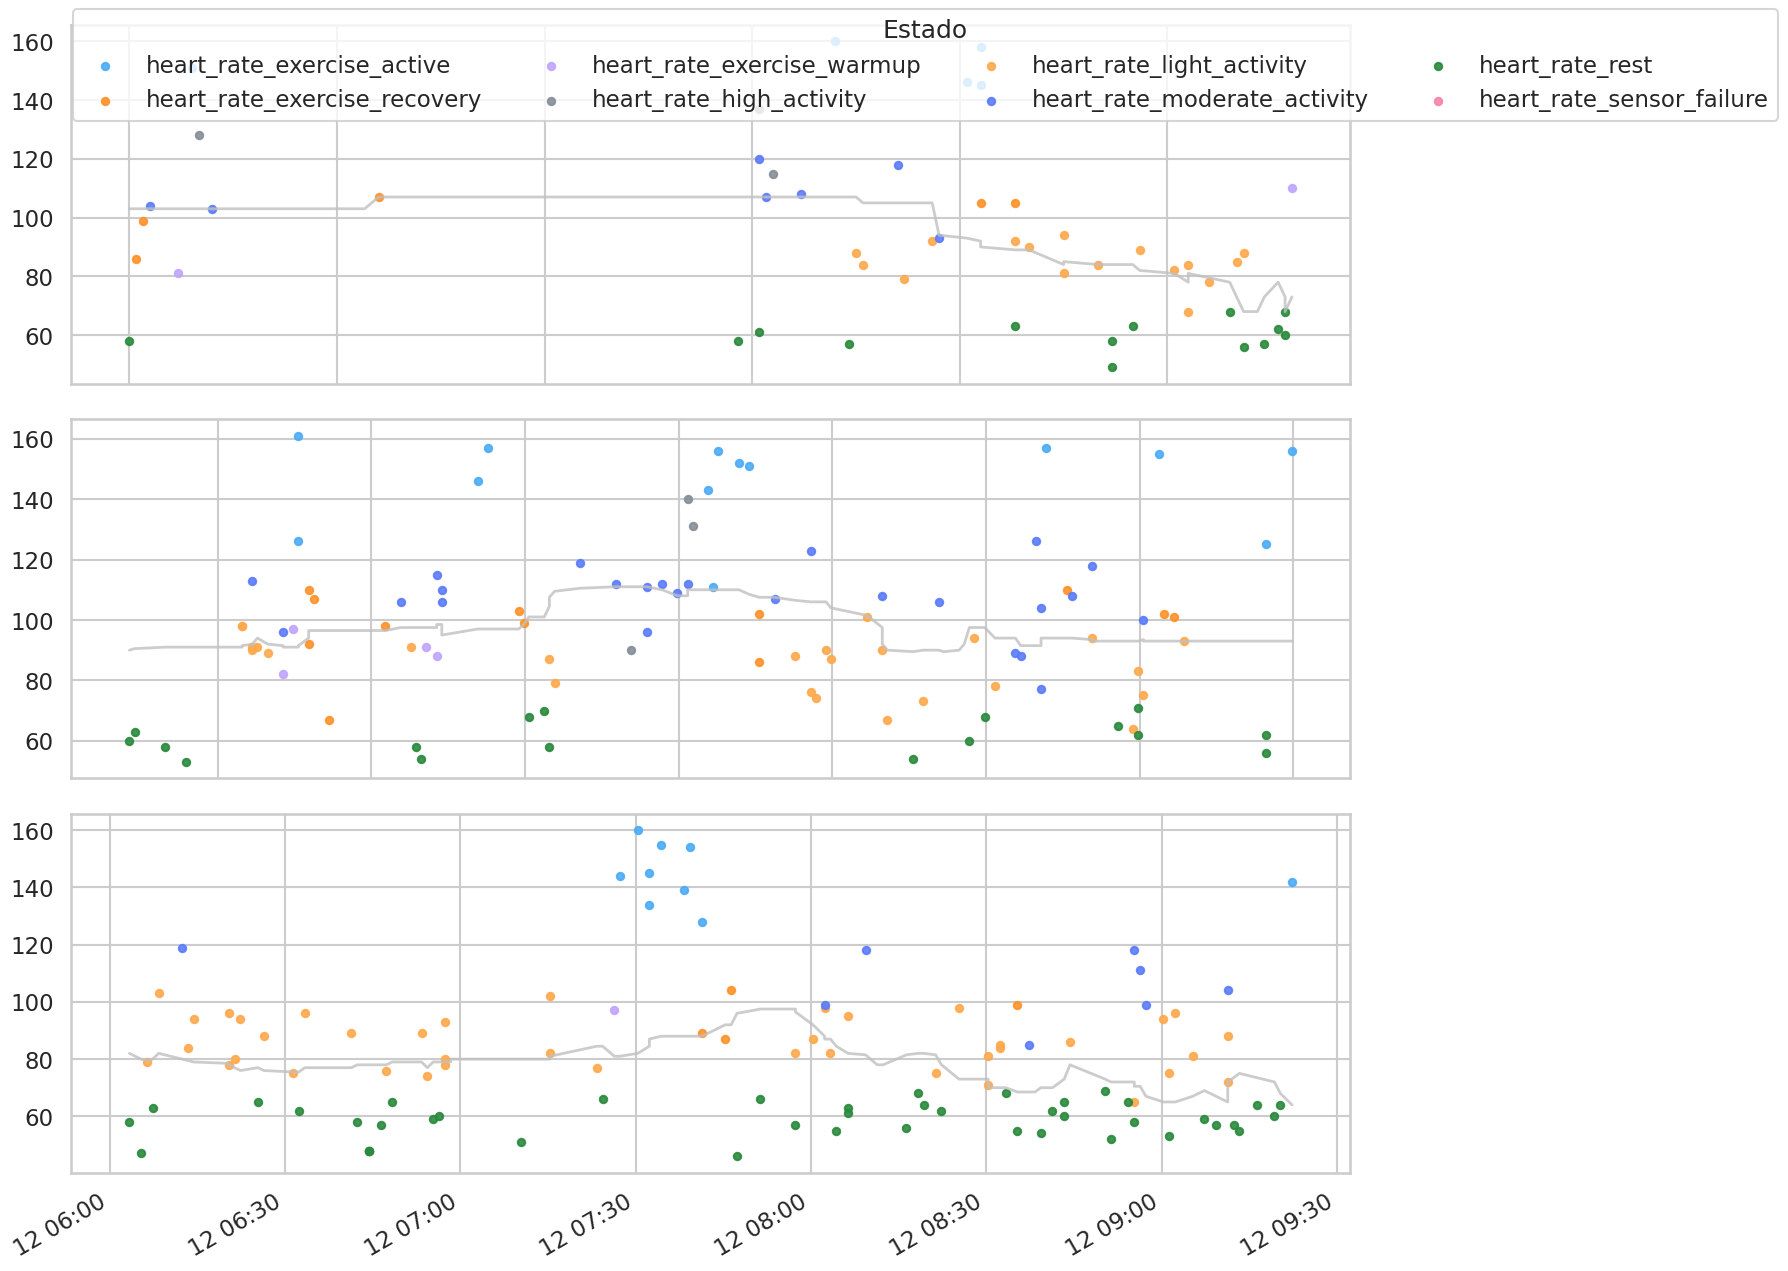

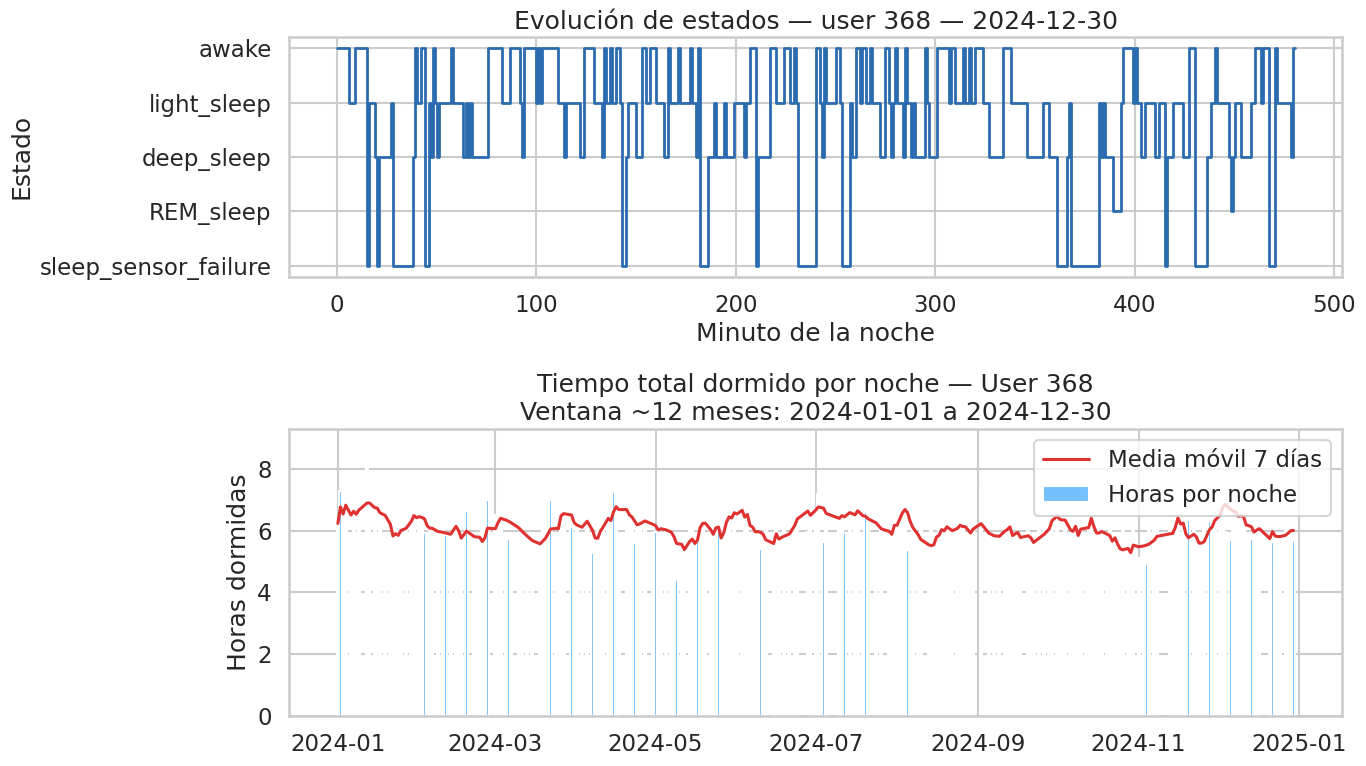

In [ ]:
# 4) Graficar HR por día (similar a tu primer collage)
example_user = str(profiles.sample(1, random_state=123)['user_id'].iloc[0])
plot_hr_day_panels(hr_df, user_id=example_user, n_days=3, seed=202, window_label='ventana=90min', thin=1)

# 5) Graficar panel de sueño (similar a tu segundo collage)
# Construimos el detalle de una noche concreta del usuario:
prow = profiles[profiles['user_id']==example_user].iloc[0]
P_sleep_u = personalize_sleep_matrix(SLEEP_BASE, prow)
one_night = sleep_nightly[sleep_nightly['user_id']==example_user]['night_date'].max()
sleep_minute_detail = build_sleep_minute_detail(P_sleep_u, one_night, example_user)
plot_sleep_panels(sleep_nightly, sleep_minute_detail, user_id=example_user, one_night_date=one_night)

In [ ]:
# 1) Calcular métricas + auxiliares
hr_metrics = compute_hr_metrics_per_night_with_support(
    hr_df=hr_df,
    nights_index=nightly_scored[['user_id','night_date']],
    k=HR_MIN_SAMPLES   # o el valor que prefieras
)

# 2) Merge con tu tabla final
nightly_df = nightly_scored.copy()
nightly_df['user_id'] = nightly_df['user_id'].astype(str)
nightly_df['night_date'] = pd.to_datetime(nightly_df['night_date'])

nightly_with_hr = nightly_df.merge(
    hr_metrics, on=['user_id','night_date'], how='left'
)

# 3) Reglas suaves para missing
nightly_with_hr['hr_count'] = nightly_with_hr['hr_count'].fillna(0).astype(int)
nightly_with_hr['hr_valid_flag'] = nightly_with_hr['hr_valid_flag'].fillna(0).astype(int)

In [ ]:
#print(nightly_with_hr[['rhr_median','hrv_proxy_median','hr_response_median','hr_count','hr_valid_flag']].isna().mean())
#print(nightly_with_hr['hr_count'].describe())
#print(nightly_with_hr['hr_valid_flag'].value_counts(dropna=False))


In [ ]:
nightly_scored

,user_id,night_date,total_hours,deep_minutes,rem_minutes,awake_minutes,sleep_latency_minutes,awakenings,failure_minutes,rhr_median,...,hr_response_median,score_S_hours,score_S_deep,score_S_rem,score_S_awake,score_S_latency,score_C_rhr,score_C_hrv,score_C_resp,recovery_score_0_1
0,1,2024-01-01,7.133333,114,29,134,2,52,49,NaN,...,NaN,0.696296,0.831776,0.0,0.0,1.0,NaN,NaN,NaN,0.343128
1,1,2024-01-02,6.666667,136,34,87,2,38,34,NaN,...,NaN,0.592593,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.346667
2,1,2024-01-03,7.583333,150,29,101,2,49,52,NaN,...,NaN,0.796296,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.383333
3,1,2024-01-04,6.866667,122,34,105,1,41,55,NaN,...,NaN,0.637037,0.980583,0.0,0.0,1.0,NaN,NaN,NaN,0.352104
4,1,2024-01-05,7.450000,129,37,100,1,41,39,NaN,...,NaN,0.766667,0.942953,0.0,0.0,1.0,NaN,NaN,NaN,0.370470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28736,300,2024-12-07,5.950000,113,7,84,2,40,61,NaN,...,NaN,0.433333,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.318000
28737,300,2024-12-12,8.000000,182,8,122,2,55,85,NaN,...,NaN,0.888889,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.400000
28738,300,2024-12-17,6.200000,136,12,82,1,39,39,NaN,...,NaN,0.488889,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.328000
28739,300,2024-12-27,6.533333,163,9,96,3,35,45,NaN,...,NaN,0.562963,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.341333


In [ ]:
nightly_labeled

,user_id,night_date,total_hours,deep_minutes,rem_minutes,awake_minutes,sleep_latency_minutes,awakenings,failure_minutes,rhr_median,...,score_S_deep,score_S_rem,score_S_awake,score_S_latency,score_C_rhr,score_C_hrv,score_C_resp,recovery_score_0_1,recovery_threshold,recovery_label_binary
0,1,2024-01-01,7.133333,114,29,134,2,52,49,NaN,...,0.831776,0.0,0.0,1.0,NaN,NaN,NaN,0.343128,0.350502,Deficient Recovery
1,1,2024-01-02,6.666667,136,34,87,2,38,34,NaN,...,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.346667,0.350502,Deficient Recovery
2,1,2024-01-03,7.583333,150,29,101,2,49,52,NaN,...,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.383333,0.350502,Adequate Recovery
3,1,2024-01-04,6.866667,122,34,105,1,41,55,NaN,...,0.980583,0.0,0.0,1.0,NaN,NaN,NaN,0.352104,0.350502,Adequate Recovery
4,1,2024-01-05,7.450000,129,37,100,1,41,39,NaN,...,0.942953,0.0,0.0,1.0,NaN,NaN,NaN,0.370470,0.350502,Adequate Recovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28736,300,2024-12-07,5.950000,113,7,84,2,40,61,NaN,...,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.318000,0.350502,Deficient Recovery
28737,300,2024-12-12,8.000000,182,8,122,2,55,85,NaN,...,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.400000,0.350502,Adequate Recovery
28738,300,2024-12-17,6.200000,136,12,82,1,39,39,NaN,...,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.328000,0.350502,Deficient Recovery
28739,300,2024-12-27,6.533333,163,9,96,3,35,45,NaN,...,1.000000,0.0,0.0,1.0,NaN,NaN,NaN,0.341333,0.350502,Deficient Recovery
